## ScanPy!

This is the easy to use modern gold standard for sequencing analysis in python. Okay lets go. I use the example dataset from the ScanPy website. Let's go.

ScanPy uses AnnData structures, see AnnData Tutorial.

In [22]:
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import seaborn as sns
import scipy.stats as st
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt

sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    frameon=False,
)

### Reading Data

ScanPy has methods for reading different sequencing files. The one we use is ".h5ad" which is commonly used with ScanPy I think. Here we simply plug in the raw data file paths and call the read function.

In [2]:
# Reading the raw data into a quick dictionary
adatas = {"s1d1": sc.read_10x_h5(r"C:\Users\Johann\Documents\Coding\Python\Master Thesis\Data\s1d1_filtered_feature_bc_matrix.h5"),
          "s1d3": sc.read_10x_h5(r"C:\Users\Johann\Documents\Coding\Python\Master Thesis\Data\s1d3_filtered_feature_bc_matrix.h5")}

adatas["s1d1"].var_names_make_unique()
adatas["s1d3"].var_names_make_unique()

adata = ad.concat(adatas, label= "sample")
adata.obs_names_make_unique() # Because we merge two files, we get duplicates

# Show size of the two samples
print(adata.obs["sample"].value_counts())

C:\Users\Johann\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
C:\Users\Johann\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


sample
s1d1    8785
s1d3    8340
Name: count, dtype: int64


C:\Users\Johann\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
C:\Users\Johann\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
C:\Users\Johann\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [3]:
adata

AnnData object with n_obs × n_vars = 17125 × 36601
    obs: 'sample'

### Quality Control

We use the function `.calculate_qc_metrics()` to get common QC metrics like:
- Mitochondrial Gene proportion
- Ribosomal genes
- Hemoglobin genes
- gene counts per cell
- cell counts per gene

For this ScanPy has the module Preprocessing or `.pp`.

But first, we need to create some additional QC variable annotations, like which genes are mitochondrial/ribosomal/whatever genes.
Remember, with `adata.var["new annotation"]` we add a row of alternative labels to the columns (variables/genes here). In this case we create 3 new rows that get added as an annotation row on top of the matrix: mitochondrial, ribosomal, and hemoglobin genes.

In [4]:
# mitochondrial genes have "MT-" in the name
# here we simply add an annotation row above the column names (vars)
# to indicate which ones are mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-") # a long boolean list
adata.var[adata.var["mt"]] # this way we can display all the vars (columns/genes) that are TRUE for mitochondrial

adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
adata.var[adata.var["ribo"]]

adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]") # regex to filter out hemoglobin genes
adata.var[adata.var["hb"] | adata.var["ribo"] | adata.var["mt"]]

,mt,ribo,hb
RPL22,False,True,False
RPL11,False,True,False
RPS6KA1,False,True,False
RPS8,False,True,False
RPL5,False,True,False
...,...,...,...
MT-ND4L,True,False,False
MT-ND4,True,False,False
MT-ND5,True,False,False
MT-ND6,True,False,False


Now we calculate the actual QC metrics, including and referring back to the gene subsetting that we just annotated.

In [5]:
# Now we can calculate QC metrics for only the subsets of genes
sc.pp.calculate_qc_metrics(adata, qc_vars= ["mt", "ribo", "hb"],
                           inplace= True,
                           log1p= True)

adata.obs # look, QC metrics get added for each observation, they include the percentage of different gene groups as defined before
# as well as some summaries of gene counts

,sample,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,total_counts_ribo,log1p_total_counts_ribo,pct_counts_ribo,total_counts_hb,log1p_total_counts_hb,pct_counts_hb
AAACCCAAGGATGGCT-1,s1d1,2103,7.651596,8663.0,9.066932,42.721921,59.667552,69.744892,79.348955,460.0,6.133398,5.309938,3650.0,8.202756,42.133209,17.0,2.890372,0.196237
AAACCCAAGGCCTAGA-1,s1d1,3916,8.273081,12853.0,9.461411,35.843772,44.262040,52.376877,62.763557,1790.0,7.490530,13.926710,1719.0,7.450079,13.374310,58.0,4.077538,0.451257
AAACCCAAGTGAGTGC-1,s1d1,683,6.527958,1631.0,7.397562,56.284488,62.599632,70.386266,88.779890,581.0,6.366470,35.622318,63.0,4.158883,3.862661,13.0,2.639057,0.797057
AAACCCACAAGAGGCT-1,s1d1,4330,8.373554,17345.0,9.761117,27.662150,38.420294,48.901701,62.023638,780.0,6.660575,4.496973,3936.0,8.278174,22.692417,44.0,3.806663,0.253675
AAACCCACATCGTGGC-1,s1d1,325,5.786897,555.0,6.320768,49.909910,59.459459,77.477477,100.000000,159.0,5.075174,28.648647,26.0,3.295837,4.684685,26.0,3.295837,4.684685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGAGAGTCTGG-1,s1d3,277,5.627621,615.0,6.423247,63.089431,71.219512,87.479675,100.000000,282.0,5.645447,45.853661,35.0,3.583519,5.691057,20.0,3.044523,3.252032
TTTGTTGCAGACAATA-1,s1d3,3797,8.242230,13218.0,9.489410,30.753518,44.628537,53.691935,64.684521,864.0,6.762730,6.536541,3997.0,8.293550,30.239067,42.0,3.761200,0.317749
TTTGTTGCATGTTACG-1,s1d3,3089,8.035926,27280.0,10.213945,64.409824,71.671554,78.317449,85.054985,1025.0,6.933423,3.757332,3562.0,8.178358,13.057184,13145.0,9.483872,48.185482
TTTGTTGGTAGTCACT-1,s1d3,379,5.940171,698.0,6.549651,52.865330,60.028653,74.355301,100.000000,143.0,4.969813,20.487106,58.0,4.077538,8.309455,39.0,3.688879,5.587393


### Determining Outliers with MADs

In addition to filtering out certain gene subsets we want to free our dataset from outliers. While it is possible to simply plot a bunch of QC covariates and eyeball thresholds beyond which to exclude cells, it seems to me more consistent to do it using _STATISTICS_

And that we can do by using **median absolute deviations (MAD)**. Here we define a function that, for a given QC metric, calculates the MAD. Alongside the QC metric we wanna calculate a MAD for, we also pass the number of MADs from the median beyond which we say "nah man". Like n-times standard deviation, we define n-times MAD above and below the median that we deem acceptable.

In [6]:
# Calculating MAD for a given QC metric
def is_outlier(adata, metric: str, nmads: int):
    '''This function calculates whether each element of a list or series is an
    outlier based on the number of median absolute deviations (MADs) passed in the
    arguments nmads. It returns a list of booleans where each element that was an outlier
    in the original list results in a TRUE in the returned list. If you use the returned
    list for indexing to EXCLUDE outliers, remember to index with the inverse (~outliers) of the outlier
    list returned by this function'''
    M = adata.obs[metric]
    outlier = ((M < np.median(M) - nmads * st.median_abs_deviation(M)) # outlier below ...
               | (np.median(M) + nmads * st.median_abs_deviation(M) < M)) # and outlier above
    return outlier

# Defining whether a nucleus is an outlier based on mitochondrial and total counts and percentages
# I dont know why we use the log1p here ...
adata.obs["outlier"] = (is_outlier(adata, "log1p_total_counts", 5) | is_outlier(adata, "log1p_n_genes_by_counts", 5))
adata.obs["mt_outlier"] = (is_outlier(adata, "pct_counts_mt", 3) | (adata.obs["pct_counts_mt"] > 60))

print(adata.obs["outlier"].value_counts(),
      adata.obs["mt_outlier"].value_counts(),
      sep= "\n\n")

outlier
False    16827
True       298
Name: count, dtype: int64

mt_outlier
False    13243
True      3882
Name: count, dtype: int64


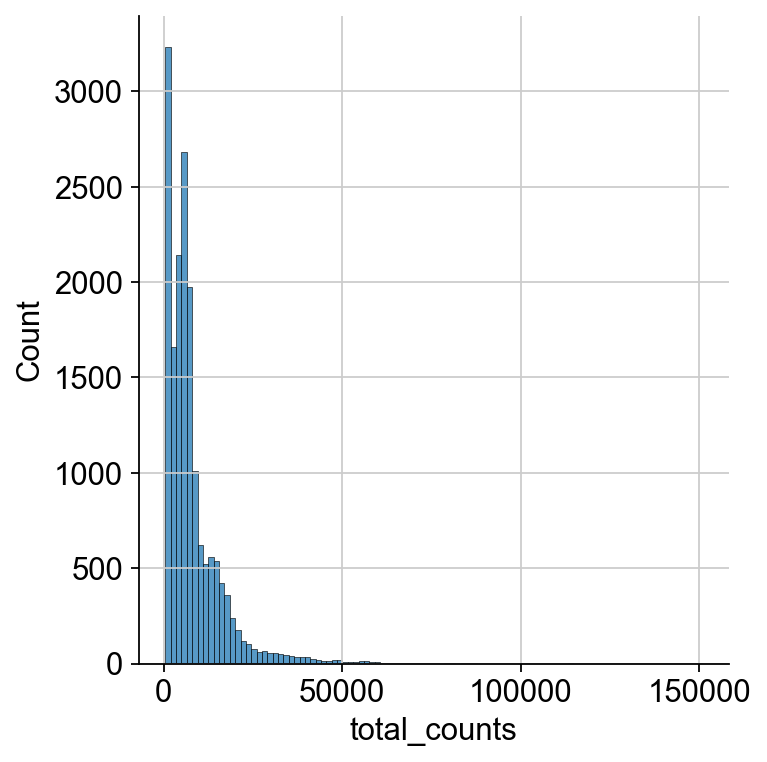

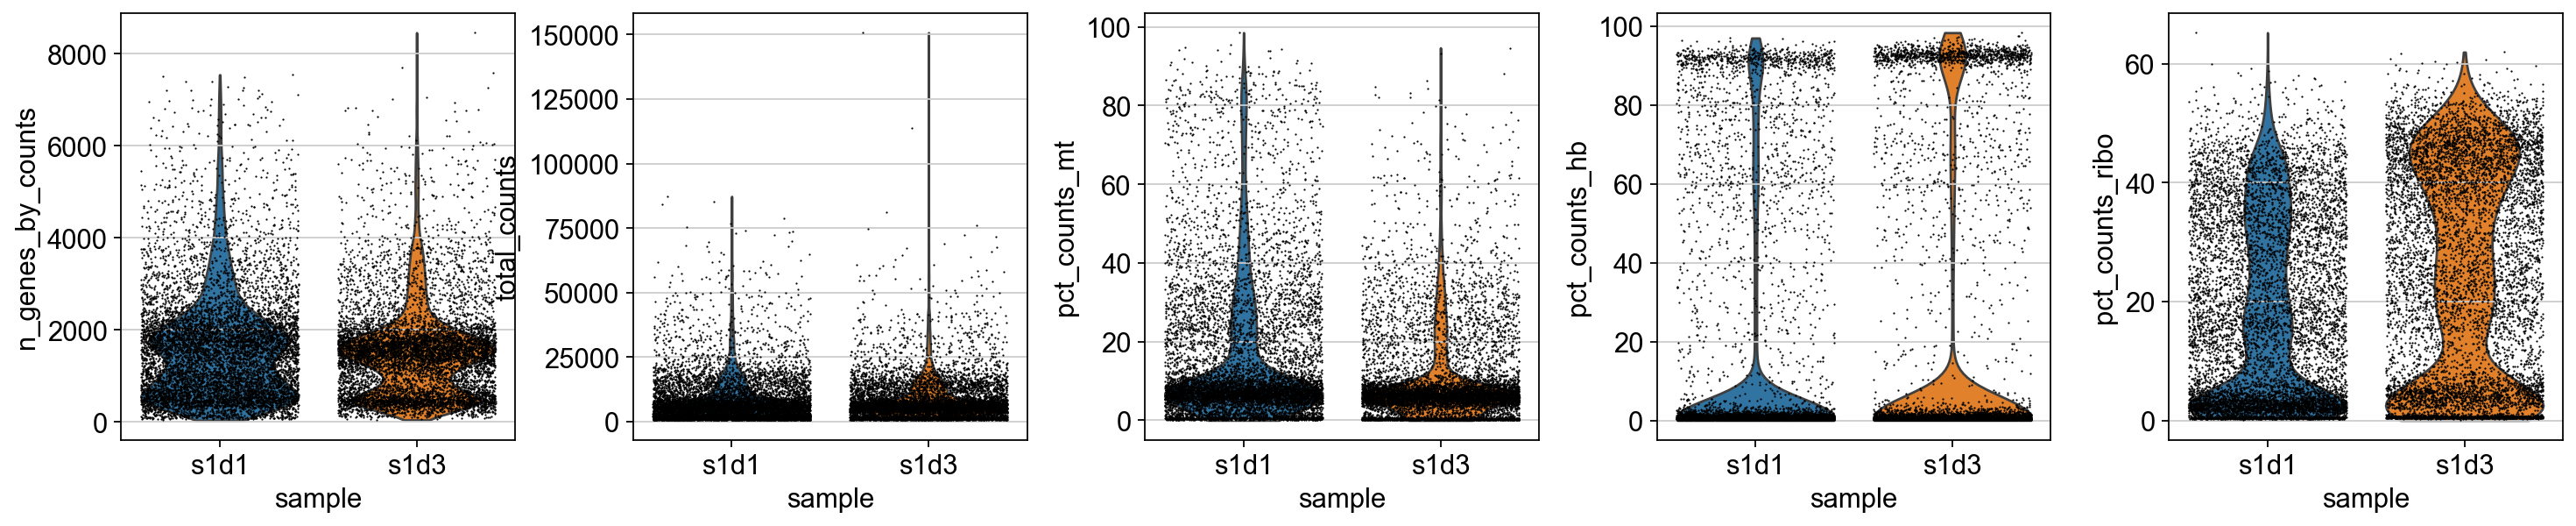

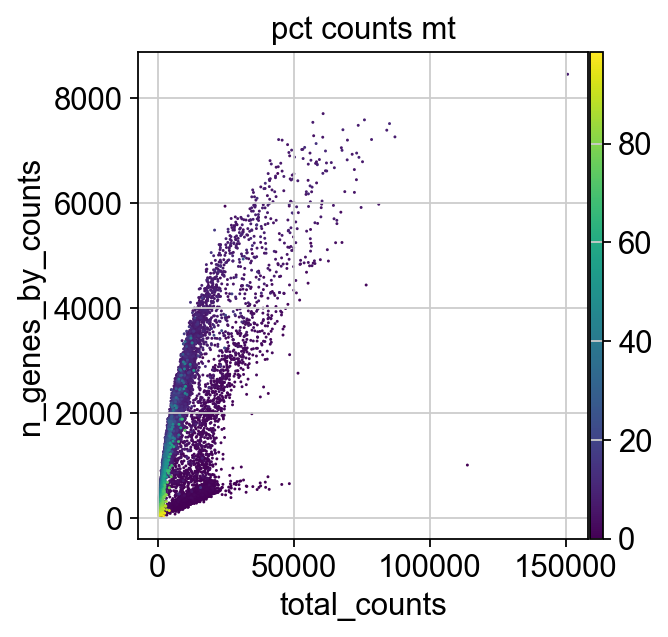

C:\Users\Johann\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\scanpy\preprocessing\_normalization.py:269: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


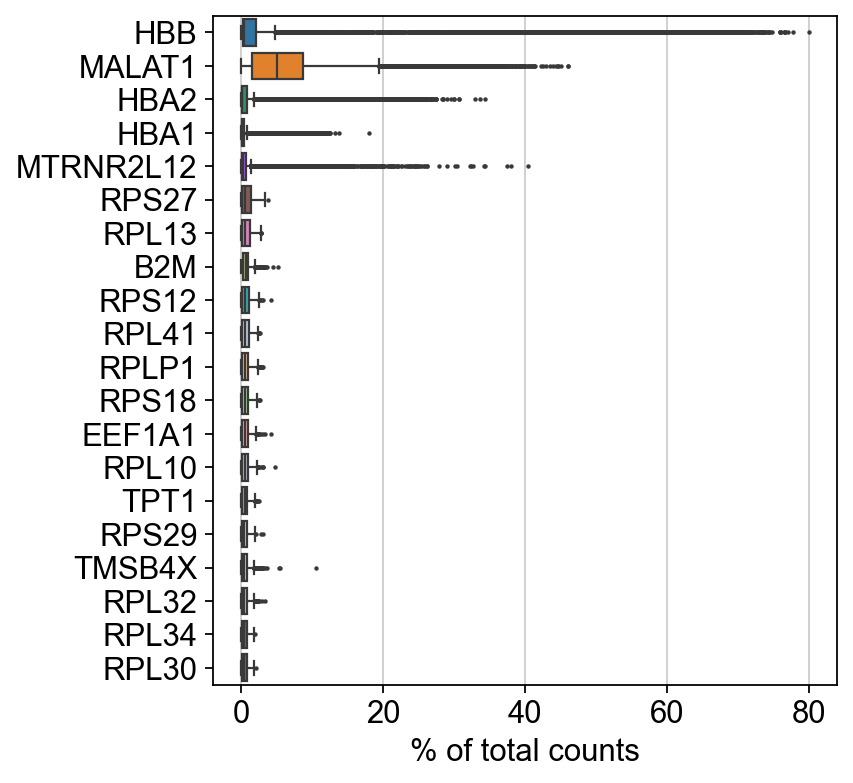

In [7]:
sns.displot(adata.obs["total_counts"], bins = 100, kde= False)

sc.pl.violin(adata,
             ["n_genes_by_counts", "total_counts", "pct_counts_mt", "pct_counts_hb", "pct_counts_ribo"],
             jitter= 0.4, # each dot is one cell/nucleus
             multi_panel= True,
             groupby= "sample") # you can group by observation labels

# mitochondrial content
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

# most highly expressed genes just for checking
sc.pl.highest_expr_genes(adata[:, adata.var["mt"] == False], n_top=20)

### Filtering

Now we use the QC metrics (gene subsets as well as the outliers) that we just calculated to actually filter out cells and genes from the count matrix.

For this you could use simply slicing by observation (qc metric) or the specific `.filter_cells` and `.filter_genes` methods.

In [8]:
# You could do it like this and simply save the view (the subset) to a new variable
adata[adata.obs["n_genes_by_counts"] >= 100].to_df()
adata[:, adata.var["n_cells_by_counts"] >= 3].to_df()

# And this is also what we have to do with out custom "outlier" annotations
print(f"Number of cells before outliers: {adata.n_obs}")
adata = adata[(~adata.obs["outlier"]) & (~adata.obs["mt_outlier"])]
print(f"Number of cells after outliers: {adata.n_obs}\n")

# Or there's extra functions for exclusions
print(f"Number of cells before count exclusion: {adata.n_obs}")
sc.pp.filter_cells(adata, min_genes= 100, inplace= True)
sc.pp.filter_genes(adata, min_cells= 20, inplace= True)
print(f"Number of cells after count exclusion: {adata.n_obs}")

adata #dimensions match regardless which you use

# And if we check again now
adata[adata.obs["n_genes_by_counts"] < 100].to_df() # Theres nothing in there anymore! (inplace= True, also)
adata[:, adata.var["n_cells_by_counts"] < 20].to_df() # Here neither

Number of cells before outliers: 17125
Number of cells after outliers: 13194

Number of cells before count exclusion: 13194


C:\Users\Johann\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\scanpy\preprocessing\_simple.py:176: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


Number of cells after count exclusion: 13194


""
AAACCCAAGGATGGCT-1
AAACCCAAGGCCTAGA-1
AAACCCACAAGAGGCT-1
AAACCCAGTCCGCAGT-1
AAACCCAGTGCATACT-1
...
TTTGGTTGTCTCACAA-1
TTTGGTTTCCGTCCTA-1
TTTGTTGCAGACAATA-1
TTTGTTGCATGTTACG-1


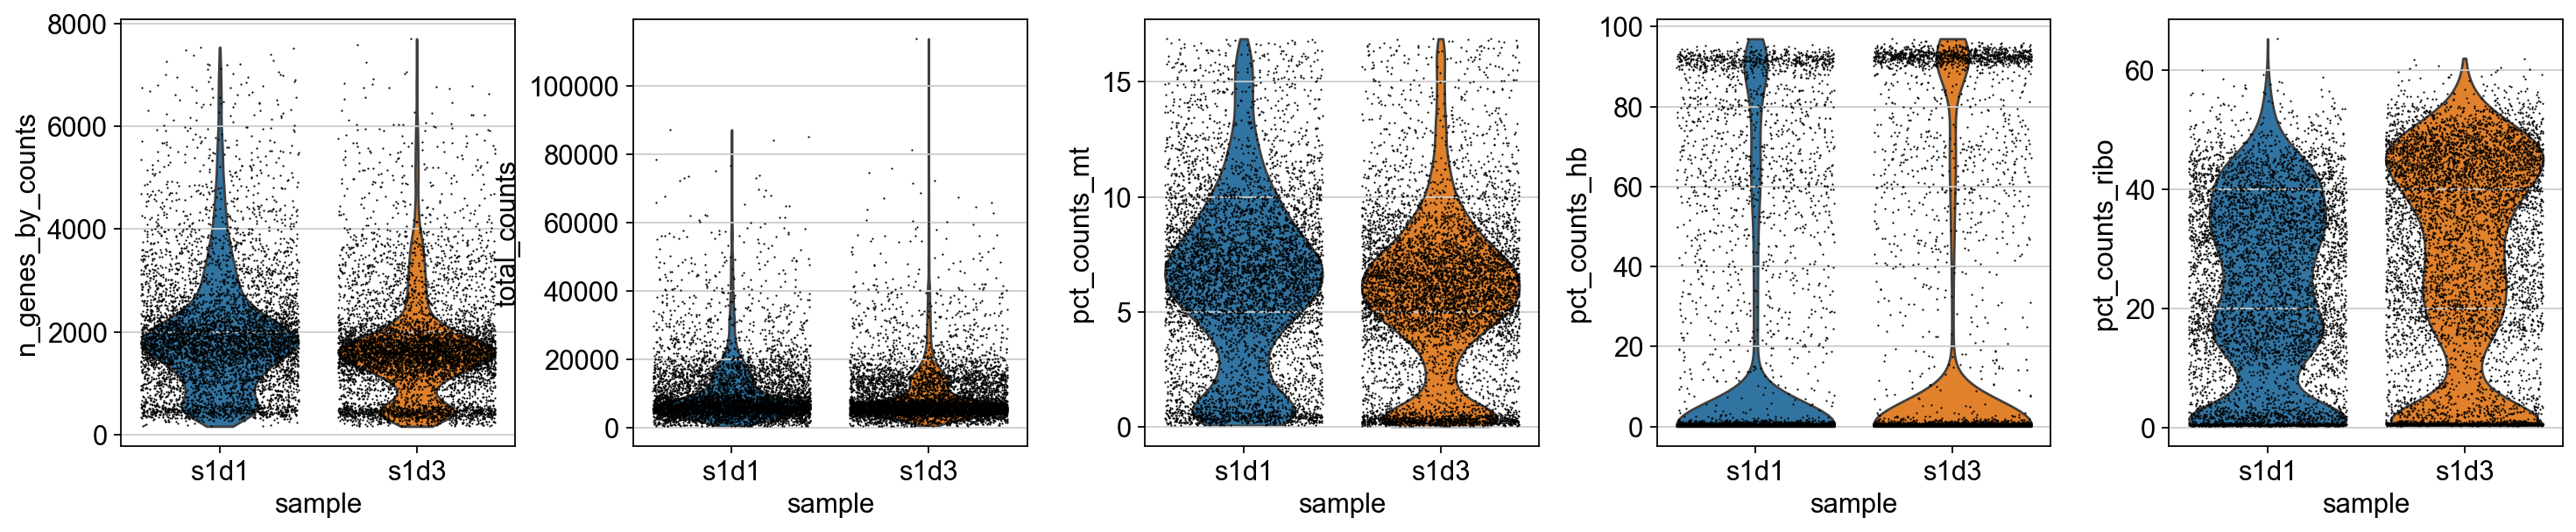

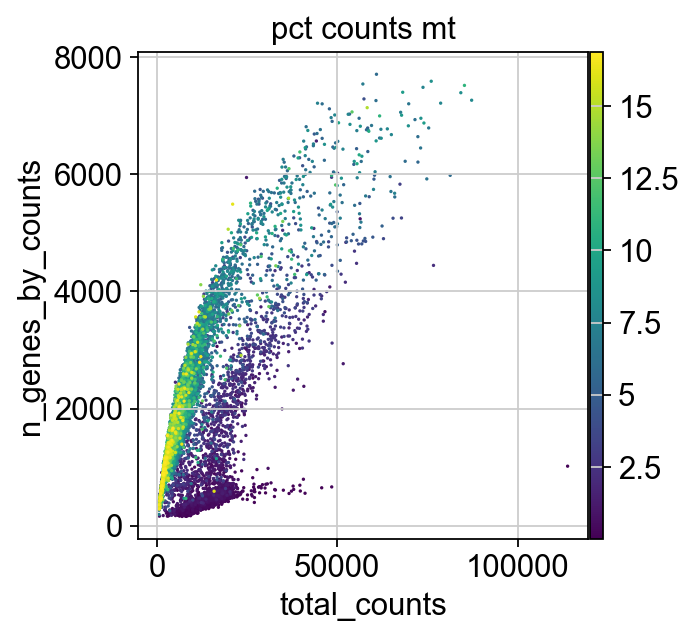

In [9]:
# Now they be looking ... better? I think ... yea, Im sure they look better
sc.pl.violin(adata,
             ["n_genes_by_counts", "total_counts", "pct_counts_mt", "pct_counts_hb", "pct_counts_ribo"],
             jitter= 0.4, # each dot is one cell/nucleus
             multi_panel= True,
             groupby= "sample") # you can group by observation labels

sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

### Doublet detection

As a next step, we run a doublet detection algorithm. Doublets, in general, are two cells/nuclei that got the same barcode because (in our case) they were plopped into the same well on the plate by accident. There's two different kinds of doublets:
- homotypic (same cell type, not an issue really)
- heterotypic (two different cell types, BAD! will mess up the data down the line)

The easiest way of seeing doublets would be the abnormally high counts (because they are essentially double the normal RNA amount), however, this can be wildly inaccurate. Instead, what is more commonly done, is that we run an algorithm, that randomly picks out two barcodes, averages their expression profiles and saves that as a new "artificial doublet". Then PC dimensionality reduction is run on all the cells together with the newly created artificial doublets and the nearest neighbours of the artificial doublets are analysed. Then a doublet-score is calculated based on the neighbours (fraction of artificial doublets in a cells neighbourhood) and the original two subsampled REAL cells/nuclei are being "rated/scored" for how likely it is that they are in fact a doublet. We can then threshold out cells that exceed a certain doublet score.

NOTE: It is **not recommended** to run doublet detection algorithms on aggregated data (from different batches/samples) without batch correction! This is why we specify the `batch_key`.

In [10]:
# Calling the scrublet function
sc.pp.scrublet(adata, batch_key= "sample") # we define batches, we use this because we havent checked the samples for batch differences

# Look, those have been created
adata.obs[["doublet_score", "predicted_doublet"]]

adata.write_h5ad("CBA_3mo_SGN_QCed.h5ad", compression= "gzip")

### Normalization

Since each step of RNA sequencing introduces its own variability into the data, there's big discrepancies in the count depth in between seemingly similar cells. This is bad, mkay, for statistics, mkaay? So basically we scale the counts (read depth) of each cell in such a way that the variances in between all cells become more similar. For this there are a few common methods that are all suitable for different purposes (non-exhaustive):
- Shifted Logarithm Transformation (suited for dim-red and subsequent differential gene expression analysis)
- Scran Normalization (good for batch correction stuff!)
- Analytic approximation of Pearson Residuals (well suited for selecting biologically variable genes and identify rare cell types)

In general: Scaling/Normalising of counts is done to a certain "size factor" like counts-per-10k (CP10k) or counts-per-million (CPM).
ScanPy has the functions `pp.normalize_total()` for that with the parameter `target_sum` controlling the size factor.

Notes: When using logarithm shifting, it is not recommended to use fixed size values like 10^5 or 10^6 because it can lead to greater overdispersion (variability) than the original dataset contained. Use the median read depth (`np.median(adata.obs["total_counts"])`) instead!

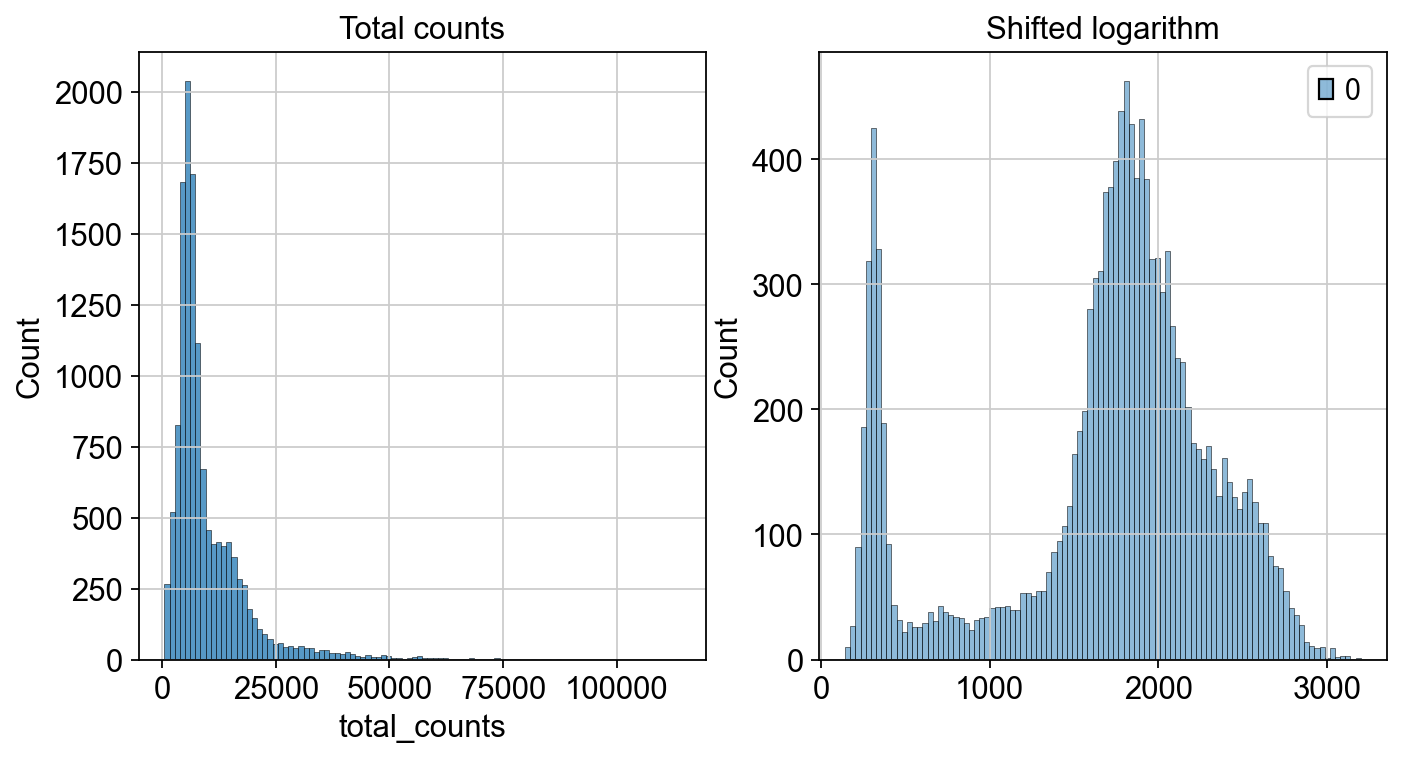

matrix([[1920.4951],
        [2721.0217],
        [2846.3254],
        ...,
        [2686.6992],
        [1585.9556],
        [1613.3335]], shape=(13194, 1), dtype=float32)

In [28]:
# SHIFTED LOGARITHM METHOD

# Normalizing by the median
scaled_counts = sc.pp.normalize_total(adata, target_sum=None, inplace=False)
# log1p transform
adata.layers["log1p_norm"] = sc.pp.log1p(scaled_counts["X"], copy=True)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")

sns.histplot(adata.layers["log1p_norm"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("Shifted logarithm")

plt.show()

adata.layers["log1p_norm"].sum(1) #this sums the counts of the actual matrix row wise (horizontally)
# Because when we created the layer we only saved the .X of the AnnData object (??)

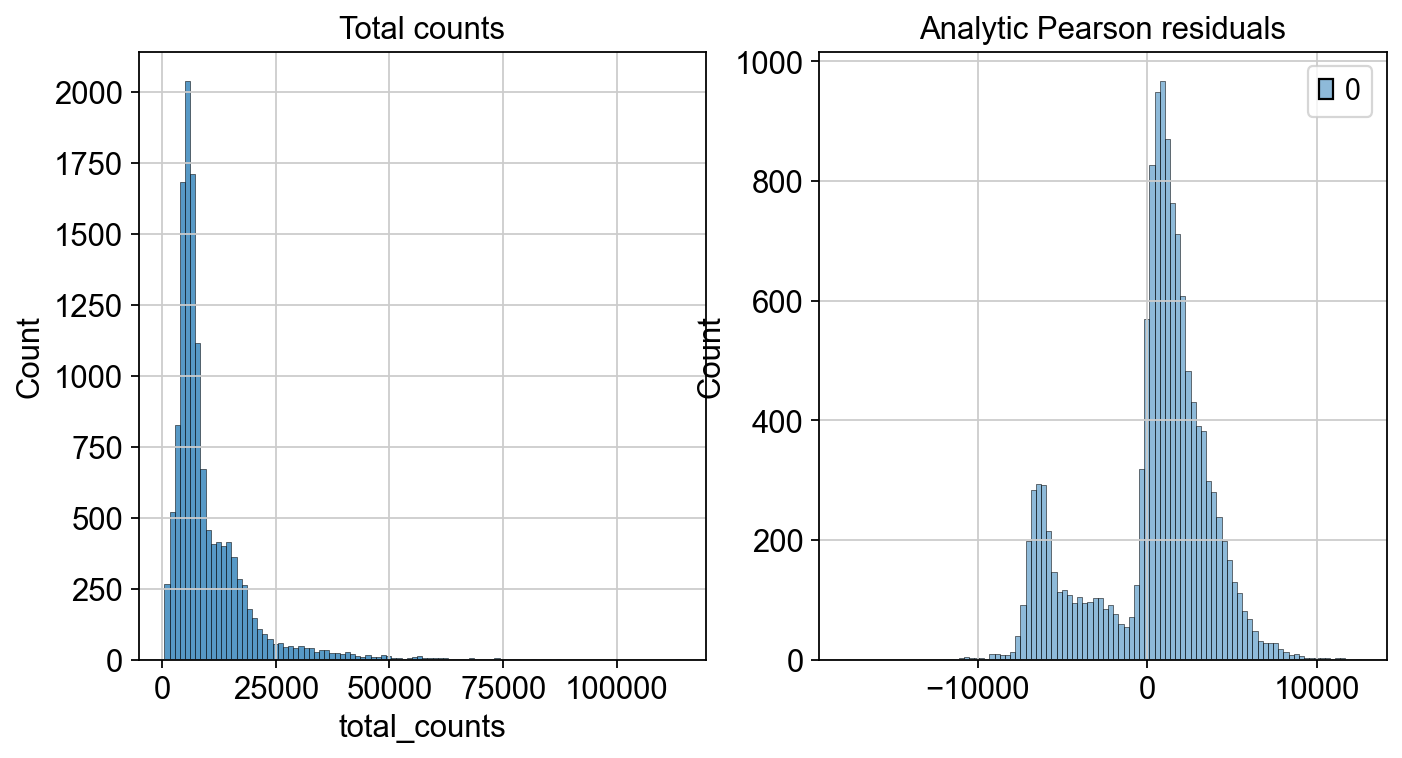

In [29]:
# Scran Normalization can be done in R ...

# PEARSON RESIDUALS METHOD
analytic_pearson = sc.experimental.pp.normalize_pearson_residuals(adata, inplace=False)
adata.layers["analytic_pearson_residuals"] = csr_matrix(analytic_pearson["X"])

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")

sns.histplot(adata.layers["analytic_pearson_residuals"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("Analytic Pearson residuals")

plt.show()

In [42]:
# sns.histplot(adata.obs["total_counts"], bins=100, kde=False)

# sns.histplot(adata.layers["analytic_pearson_residuals"].sum(1), bins= 100, kde= False)

# Normalizing to median total counts
# sc.pp.normalize_total(adata)
# Logarithmize the data
# sc.pp.log1p(adata)

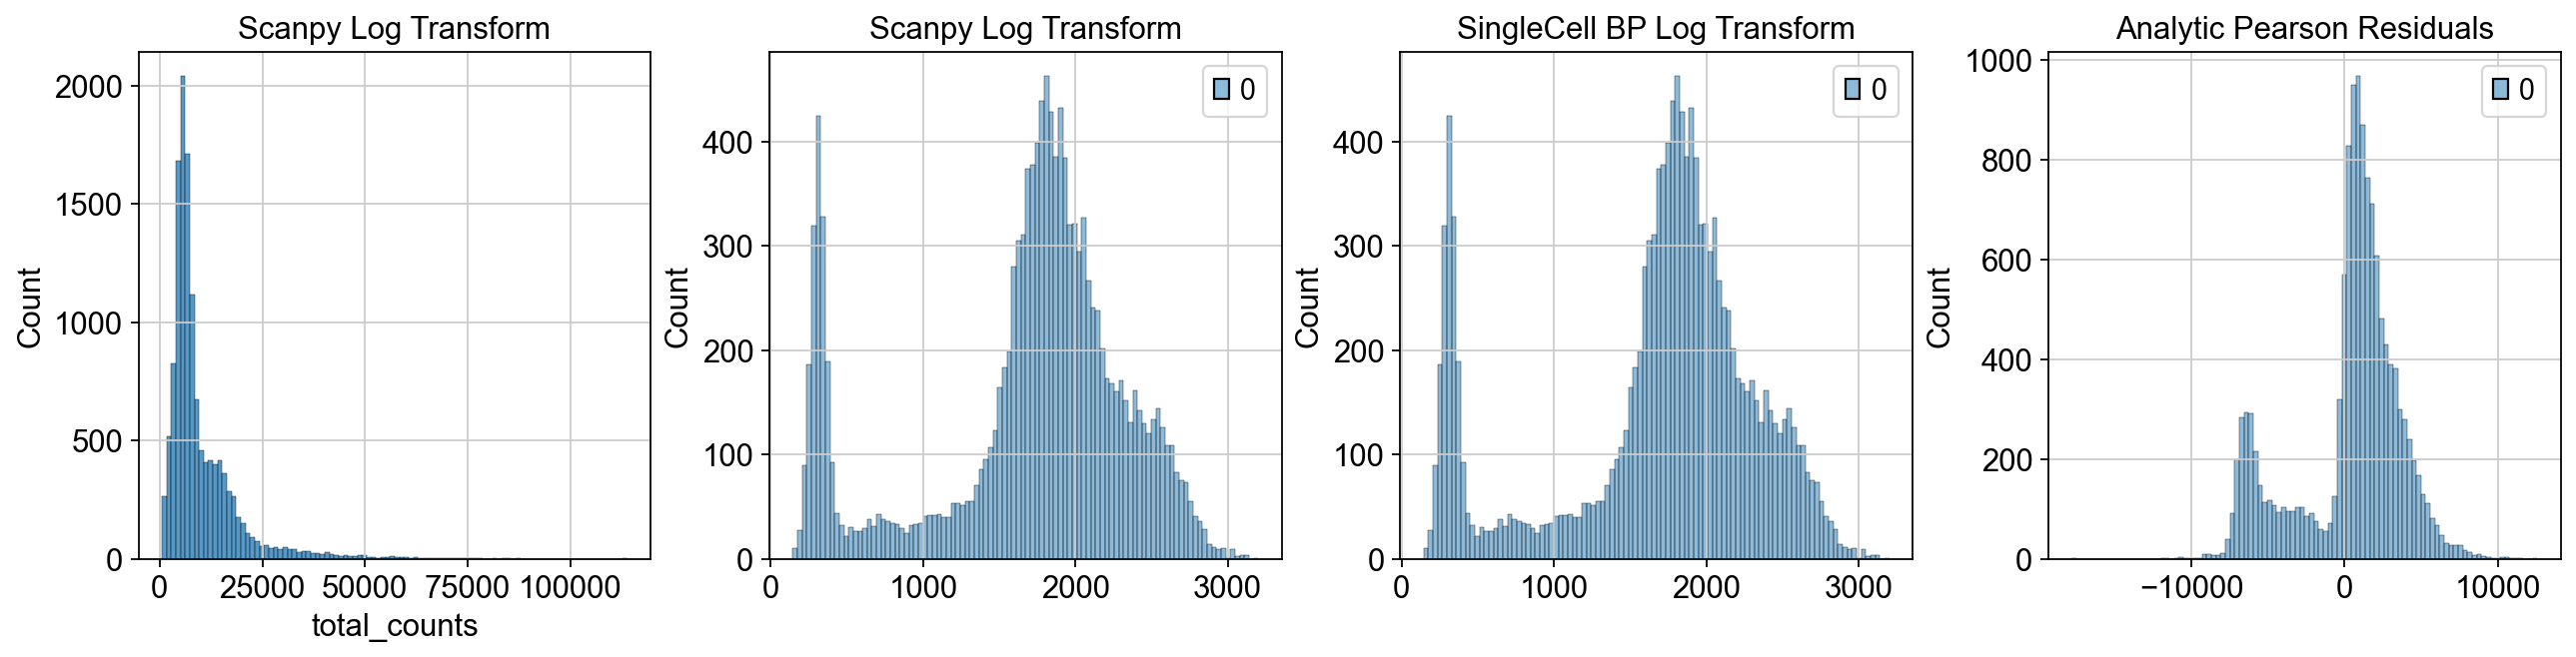

In [43]:
# Plotting for comparison!
fig, axs = plt.subplots(1,4, figsize= (16, 4), layout= "constrained")

sns.histplot(adata.obs["total_counts"], bins= 100, kde= False, ax= axs[0])
axs[0].set_title("Scanpy Log Transform")

sns.histplot(adata.X.sum(1), bins= 100, kde= False, ax= axs[1])
axs[1].set_title("Scanpy Log Transform")

sns.histplot(adata.layers["log1p_norm"].sum(1), bins= 100, kde= False, ax= axs[2])
axs[2].set_title("SingleCell BP Log Transform")

sns.histplot(adata.layers["analytic_pearson_residuals"].sum(1), bins= 100, kde= False, ax= axs[3])
axs[3].set_title("Analytic Pearson Residuals")

plt.show()

### Feature Selection

As a preliminary step to reduce the dimensionality of the data we can exclude low variability genes from the start. For this, ScanPy conveniently possesses the function `.pp.highly_variable_genes()` which takes the dataset and extracts the n-most highly variable genes according to the parameter `n_top_genes= n`.

We do this because as it is now, in the normalized count matrix, there are still a bunch of features (genes! variables! you know) that are mostly zero counts or that do not meaningfully vary across cells and thus do not represent any biological variation that we can use here. So! We find them, select them, and filter them out!

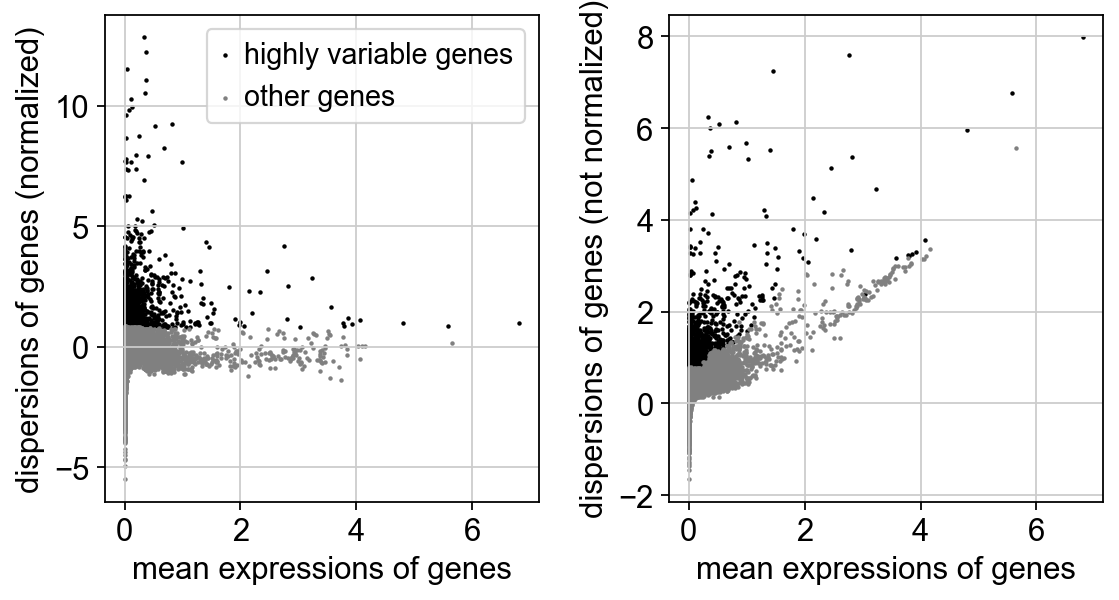

In [56]:
# Highly variable jeans
sc.pp.highly_variable_genes(adata, n_top_genes= 2000, batch_key= "sample") # Still! define batches!
adata.var.iloc[:, -6:-1] #it adds these annotations to the variables! We can now filter after "highly variable"

# Reminder! All of this is done on the normalised and log-shifted data set now!

sc.pl.highly_variable_genes(adata)